# Train Neural Net
> NN training notebook

### To-do
---
- Early stopping
- Repeats
- Rename `epochs` ---> `max_epochs`
- "Best model" saving after training and selecting best model using some kind of criteria:
```python
import pickle
file_name = '/tmp/mymodel.pkl'
# Save
with open(file_name, 'wb') as f:
    pickle.dump(net, f)
# Load it back when needed
with open(file_name, 'rb') as f:
    new_net = pickle.load(f)
```

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

In case if you want to use CUDA-enabled GPU

- the for using GPU is not yet complete, but could still work.
- Need to implement mini-batch
- Right now tensors are copied to GPU from the beginning, which won't work for large datasets as we will fill up the GPU memory. But this way is faster as we don't spend time copying the tensors between devices.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cpu


## Training

`nn` module implements these networks (not the same as torch.nn):
- `fcNet` : fully-connected neural network, linear layer as a final layer (a.k.a. linear combiner)
    - e.g. Initialise network with two (hidden) layers, with dimensions `[8, 4]`
    ```python
model = fcNet(input_dim, layer_dims=[8,4], output_dim=1)
Y = model(x)
```
- `diffNet` : difference network. `diffNet(x,Y0) = Y0 + fcNet(x)`
    - e.g. Init. diff. net with 3 hidden layers, with dim-s `[16,8,4]`
    ```python
model = diffNet(input_dim, layer_dims=[16,8,4], output_dim=1)
Y = model(x, Y0)
```

In [ ]:
from torch.nn import MSELoss

In [ ]:
# Neural network implementations: fcNet, diffNet
from nnets import fcNet, diffNet, get_model, train_model

### Persistence

In [ ]:
with open('persistence_T5.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
print('Persistence:',persistence)

Persistence: {'lead_time': 5, 'persist_train': 0.2327336031793491, 'persist_test': 0.2318496255028971}


### Naive Window

In [ ]:
# Training data
with open('train_preprocessed_naivewin6.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_diffwin6.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([23022, 7]) torch.float32,
test: torch.Size([9862, 7]) torch.float32


In [ ]:
# x = X_train[:,1:].to(device) # Y(T+0),..., Y(T-5)
y = X_train[:,:1].to(device) # Y(T+5)
# features mean, s.d.
x = torch.zeros((X_train.shape[0],3))
x[:,0] = X_train[:,1]
x[:,1] = X_train[:,1:].mean(dim=1)
x[:,2] = X_train[:,1:].std(dim=1)
x = x.to(device)
print(f'Training x {x.shape}')

Training x torch.Size([23022, 3])


In [ ]:
# x_test = X_test[:,1:].to(device) # Y(T+0),..., Y(T-5)
y_test = X_test[:,:1].to(device) # Y(T+5)
# features mean, s.d.
x_test = torch.zeros((X_test.shape[0],3))
x_test[:,0] = X_test[:,1]
x_test[:,1] = X_test[:,1:].mean(dim=1)
x_test[:,2] = X_test[:,1:].std(dim=1)
x_test = x_test.to(device)
print(f'Training x_test {x_test.shape}')

Training x_test torch.Size([9862, 3])


In [ ]:
# Network size:
input_dim = x.shape[1]
layer_dims = [128,128]
dropout_p = [.2] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 500    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 8.28745174407959, test_loss: 4.159670352935791
epoch 50> train_loss: 0.14746393263339996, test_loss: 0.27821728587150574
epoch 100> train_loss: 0.1326097697019577, test_loss: 0.3250811696052551
epoch 150> train_loss: 0.11781397461891174, test_loss: 0.39048469066619873
epoch 200> train_loss: 0.11417081952095032, test_loss: 0.4029485881328583
epoch 250> train_loss: 0.1127857193350792, test_loss: 0.41074079275131226
epoch 300> train_loss: 0.11186067759990692, test_loss: 0.41408422589302063
epoch 350> train_loss: 0.11042831838130951, test_loss: 0.4224953353404999
epoch 400> train_loss: 0.10970749706029892, test_loss: 0.42704519629478455
epoch 450> train_loss: 0.10960735380649567, test_loss: 0.42877447605133057


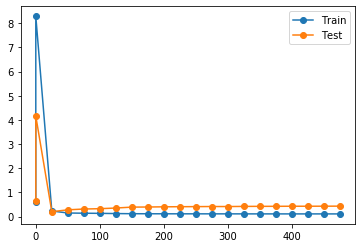

In [ ]:
net, opt = get_model('fcNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

# To re-initing weights:
from nnets import weights_init_kaiming_fanout, weights_init_kaiming_fanin
# And later use it just after initialising your net():
net.apply(weights_init_kaiming_fanin) # default Kaiming init for ReLU
# net.apply(weights_init_kaiming_fanout) # variation of above

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,x,y,(x_test, y_test), opt,
                                                  loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
# save your net!

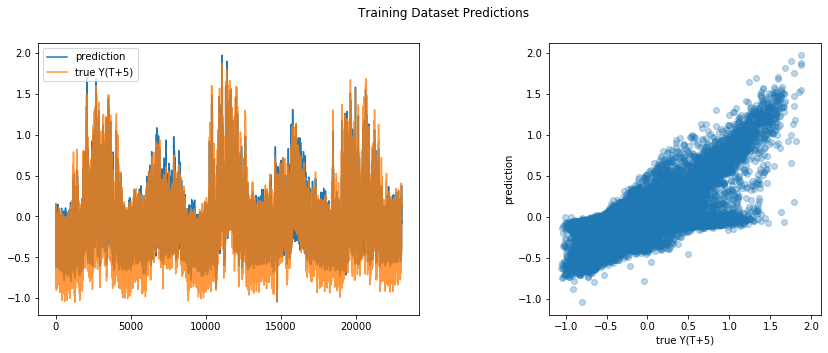

In [ ]:
net.eval()
pred = net(x).detach().numpy()
target = y.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

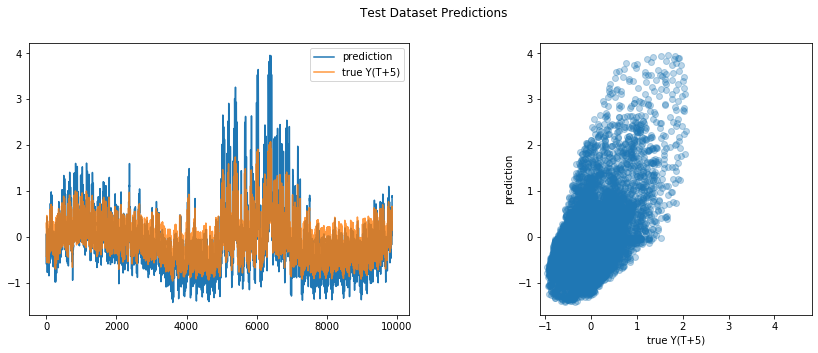

In [ ]:
net.eval()
pred_test = net((x_test)).detach().numpy()
target_test = y_test.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

In [ ]:
# another way to calculate/re-calculate MSE loss for the model
from utils import mse
mse_loss_with_np = mse(net(x_test).detach().numpy(), y_test.numpy()) # same as MSELoss()'s result
print('MSE loss:',mse_loss_with_np)

MSE loss: 0.433383


#### Lagged (Cross-) Correlation

Train lag peak:2
Test lag peak:5


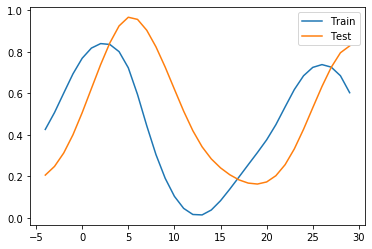

In [ ]:
from utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test).detach().numpy().ravel(),
                                      y_test.numpy().ravel())
lag_min = -5
lag_max = 30
train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
plt.plot(train_lags[train_mask],train_xcorr[train_mask],label='Train')

test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label='Test')

plt.legend();

print(f'Train lag peak:{train_lags[train_mask][np.argmax(train_xcorr[train_mask])]}')
print(f'Test lag peak:{test_lags[test_mask][np.argmax(test_xcorr[test_mask])]}')

### Difference Net

In [ ]:
# Training data
with open('train_preprocessed_diffwin12.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_diffwin12.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([23016, 13]) torch.float32,
test: torch.Size([9856, 13]) torch.float32


In [ ]:
x = X_train[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+5)

print(f'Training x {x.shape}')

Training x torch.Size([23016, 11])


In [ ]:
x_test = X_test[:,2:].to(device) # Y(T+0)-Y(T-1),Y(T-1)-Y(T-2),...,
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+5)

print(f'Training x_test {x_test.shape}')

Training x_test torch.Size([9856, 11])


In [ ]:
# Network size:
input_dim = x.shape[1]
layer_dims = [8,4]
dropout_p = [] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 0.41852906346321106, test_loss: 0.4178673028945923
epoch 100> train_loss: 0.2323714941740036, test_loss: 0.23326145112514496
epoch 200> train_loss: 0.18794162571430206, test_loss: 0.19106900691986084
epoch 300> train_loss: 0.17424611747264862, test_loss: 0.17879708111286163
epoch 400> train_loss: 0.16749756038188934, test_loss: 0.1728227138519287
epoch 500> train_loss: 0.16354496777057648, test_loss: 0.16932736337184906
epoch 600> train_loss: 0.16114263236522675, test_loss: 0.1672114133834839
epoch 700> train_loss: 0.15967313945293427, test_loss: 0.1659223884344101
epoch 800> train_loss: 0.15877282619476318, test_loss: 0.16513557732105255
epoch 900> train_loss: 0.15822166204452515, test_loss: 0.16465598344802856


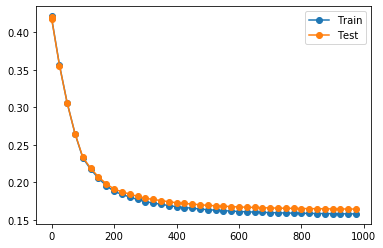

In [ ]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

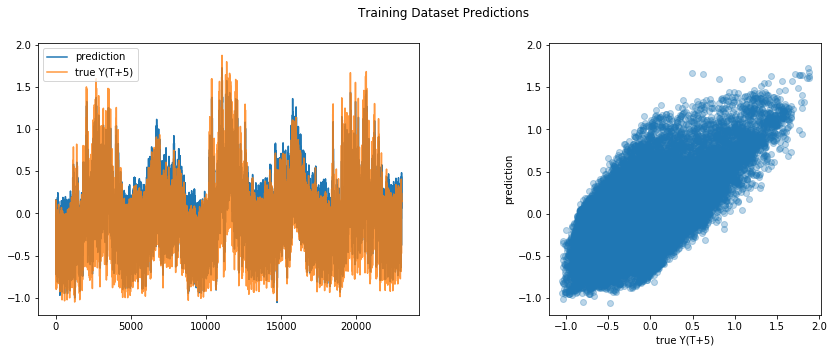

In [ ]:
net.eval()
pred = net(x,Y0).detach().numpy()
target = y.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')

plt.suptitle('Training Dataset Predictions');

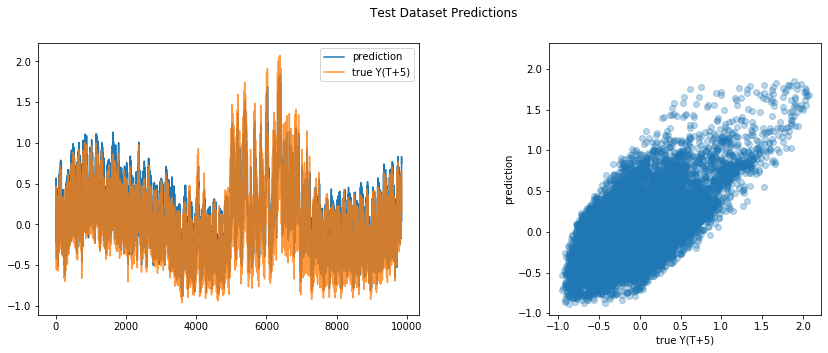

In [ ]:
net.eval()
pred_test = net(x_test,Y0_test).detach().numpy()
target_test = y_test.numpy()
_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label='true Y(T+5)',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.3)
axs[1].set_xlabel('true Y(T+5)')
axs[1].set_ylabel('prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');

Train lag peak:4
Test lag peak:4


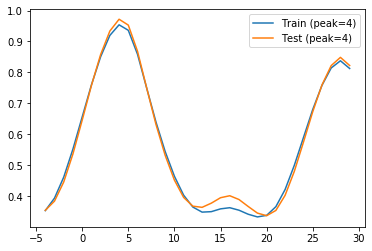

In [ ]:
from utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(x_test,Y0_test).detach().numpy().ravel(),
                                      y_test.numpy().ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)

train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})')
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})')

plt.legend();
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')